In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sb
import os
import random
from tqdm import tqdm
import pickle
from custom_tokenizer import WordPieceTokenizer

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    random.seed(2)
    
tf.config.list_physical_devices('GPU')

2024-10-18 12:14:31.672211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 12:14:31.684423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 12:14:31.688000: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 12:14:31.697443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 12:14:32.395378: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# load pretraining data for the 1st sequence and the trained tokenizer class
        
if __name__ == "__main__":

    with open('wp_tok_en.pkl','rb') as f:
        tokenizer = pickle.load(f)
        
with open('short_pretraining_data.pkl','rb') as f:
    data = pickle.load(f)


In [3]:
# get sequence maxlen

maxlen = data['train']['seq'].shape[1]

In [4]:
# build model for MLM pretraining
# this involves adding a mlm head, which is just a dense layer with softmax activation
# the output will be of shape (batch,maxlen,vocab_size)

from Bert.bert import BERT

reset_random_seeds()

input_len = maxlen
d_model = 256
n_heads = 8
vocab_size = len(tokenizer.i2w)
units = d_model // 2
n_layers = 2
batch = 32

i = tf.keras.layers.Input((input_len,),batch_size=batch,dtype=tf.int16)

bert_layer = BERT(d_model=d_model,input_len=input_len,
                  n_heads=n_heads,n_layers=n_layers,
                  units=units,vocab_size=vocab_size)



out = bert_layer(i)

out = tf.keras.layers.Dense(vocab_size,activation='softmax')(out)

model = tf.keras.Model(i,out)

model.summary()

I0000 00:00:1729233875.553678    4238 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729233875.553872    4238 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729233875.553985    4238 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729233875.601201    4238 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bert (BERT)                     │ (32, 32, 256)          │     4,513,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (32, 32, 15020)        │     3,860,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,373,676 (31.94 MB)

 Trainable params: 8,373,676 (31.94 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# set the positional encoding weights and freeze the weights
# the 1st phase will not involve training positional encodings

model.layers[1].set_positional_encoding()
model.layers[1].embedding.pos_emb_layer.trainable = False


<Axes: >

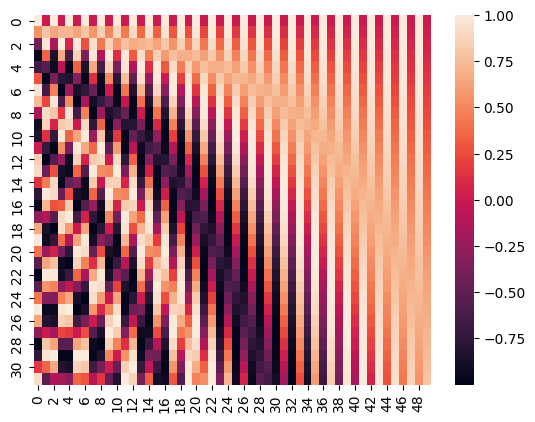

In [6]:
# visualize positional encodings

sb.heatmap(model.layers[1].embedding.pos_emb_layer.get_weights()[0][:,:50])

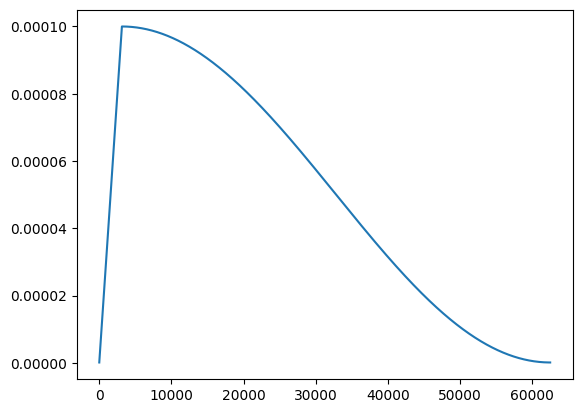

In [7]:
# initalize loss function and optimizer

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01)


# cosine lr scheduler class
# the lr would increase linearly during warmp
# and then cosine decay

class CosineLRScheduler:
    def __init__(self,total_steps,max_lr=1e-4,min_lr=1e-7,init_lr=1e-7):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.init_lr = init_lr
        self.total_setps = total_steps
        self.warmup = int(total_steps * 0.05)
        self.decay = total_steps - self.warmup
        self.warmup_lr = np.linspace(init_lr,max_lr,self.warmup)
        
        
    def __call__(self,step):
        
        if step <= self.warmup:
            
            lr = self.warmup_lr[step-1]
        else:   
            step = step - self.warmup
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(step * np.pi / self.decay))
        
        return lr

    
# get train and val data

xtrain = data['train']['masked_seq']
ytrain = data['train']['seq']

xvalid = data['valid']['masked_seq']
yvalid = data['valid']['seq']

total_steps = len(xtrain) // batch + 1


# data to tensors 
train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=batch,drop_remainder=True).shuffle(buffer_size=1000)
valid = tf.data.Dataset.from_tensor_slices((xvalid,yvalid)).batch(batch_size=batch*2)

# initialize scheduler and visualize lr scheduling
lr_scheduler = CosineLRScheduler(total_steps)

plt.plot([lr_scheduler(step) for step in range(1,total_steps+1)])


In [8]:
# get masking token

mask_token = tokenizer.w2i['<mask>']

In [9]:
# loss function is set such that it will compute the loss for the masked tokens

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        loss = loss_fn(y,pred,sample_weight=x==mask_token)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss


@tf.function
def test_step(x,y):
    pred = model(x,training=False)
    loss = loss_fn(y,pred,sample_weight=x==mask_token)
    return loss

In [10]:

# # model.load_weights('Bert/bert_mlm_10.weights.h5')


# for f in range(10):
#     model.load_weights(f'Bert/bert_mlm_{f+1}.weights.h5')
#     loss = 0
#     for i,(x,y) in enumerate(tqdm(valid)):
#             loss += test_step(x,y)
        
    
#     loss = np.round((loss / (i+1)).numpy(),4)
#     print(f+1,'\t',loss)
#     print()


In [11]:
##### loss = 0
# for i,(x,y) in enumerate(tqdm(train)):
#         loss += test_step(x,y)


# loss = np.round((loss / (i+1)).numpy(),4)
# print(loss)

In [12]:
# function to get sample output

def sample_output(x,y):
    
    masked_idx = np.where(x == mask_token)[0]
    x = x[tf.newaxis,:]
    p = model(x)[0]
    p = np.argmax(p,axis=-1)
    pred_masked = p[masked_idx]
    pred_masked = [tokenizer.i2w[t] for t in pred_masked]
    print('predicted tokens :',pred_masked)
    masked_target = y[masked_idx]
    masked_target = [tokenizer.i2w[t] for t in masked_target]
    print('actual tokens :',masked_target)


i = 1
x_sample = data['valid']['masked_seq'][i]
y_sample = data['valid']['seq'][i]
idx = np.where(x_sample!=0)[0][-1]
out=sample_output(x_sample,y_sample)



predicted tokens : ['lockdown', 'rodent', 'lockdown']
actual tokens : ['care', 'convey', 'wishes']


EPOCH : 1/10


100%|███████████████████████████████████████| 5543/5543 [01:25<00:00, 64.49it/s]


train_loss : 0.417
val_loss : 0.3676
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['not', '00', 'way']
actual tokens : ['care', 'convey', 'wishes']


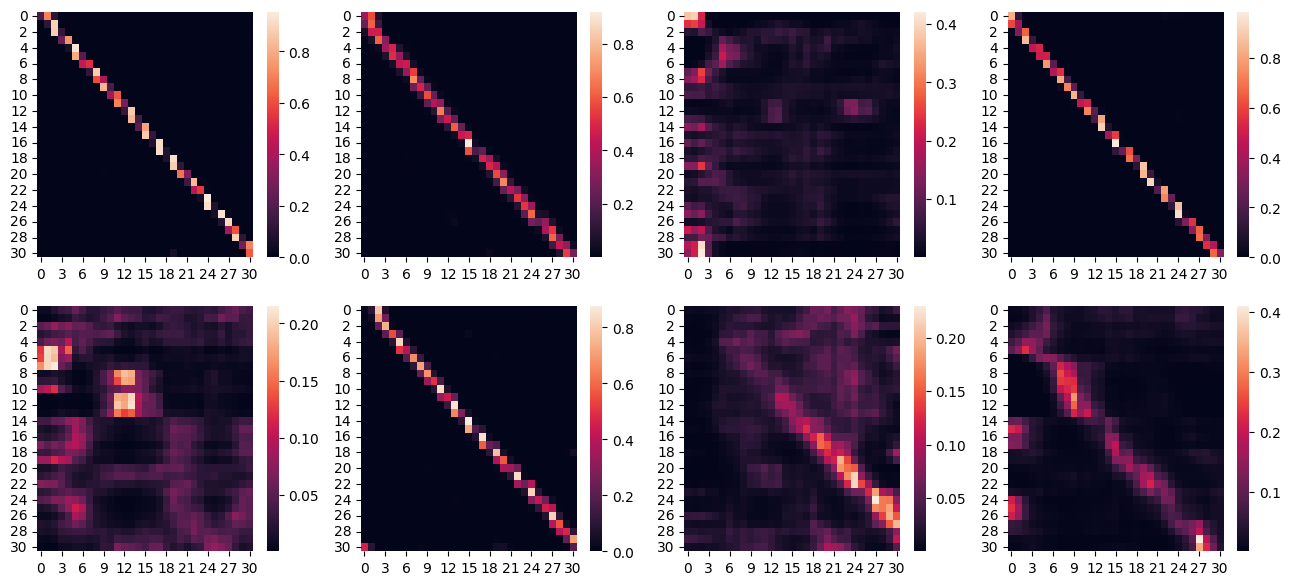


EPOCH : 2/10


100%|███████████████████████████████████████| 5543/5543 [01:25<00:00, 64.60it/s]


train_loss : 0.3482
val_loss : 0.3289
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['not', 'he', 'way']
actual tokens : ['care', 'convey', 'wishes']


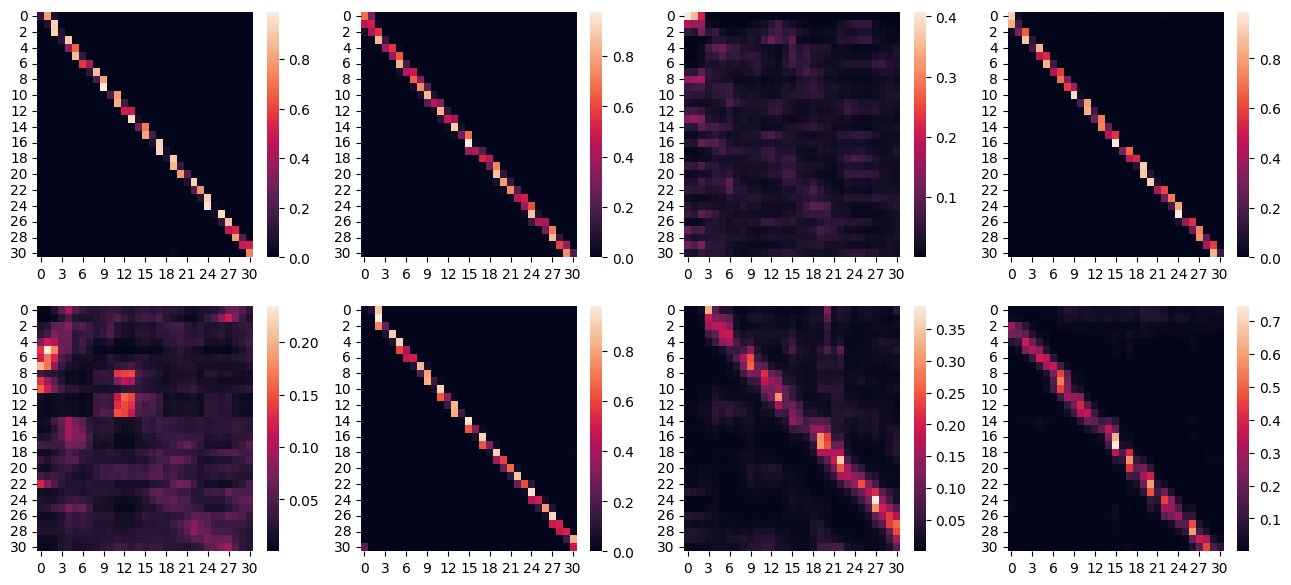


EPOCH : 3/10


100%|███████████████████████████████████████| 5543/5543 [01:25<00:00, 64.58it/s]


train_loss : 0.3234
val_loss : 0.3102
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['know', 'he', 'way']
actual tokens : ['care', 'convey', 'wishes']


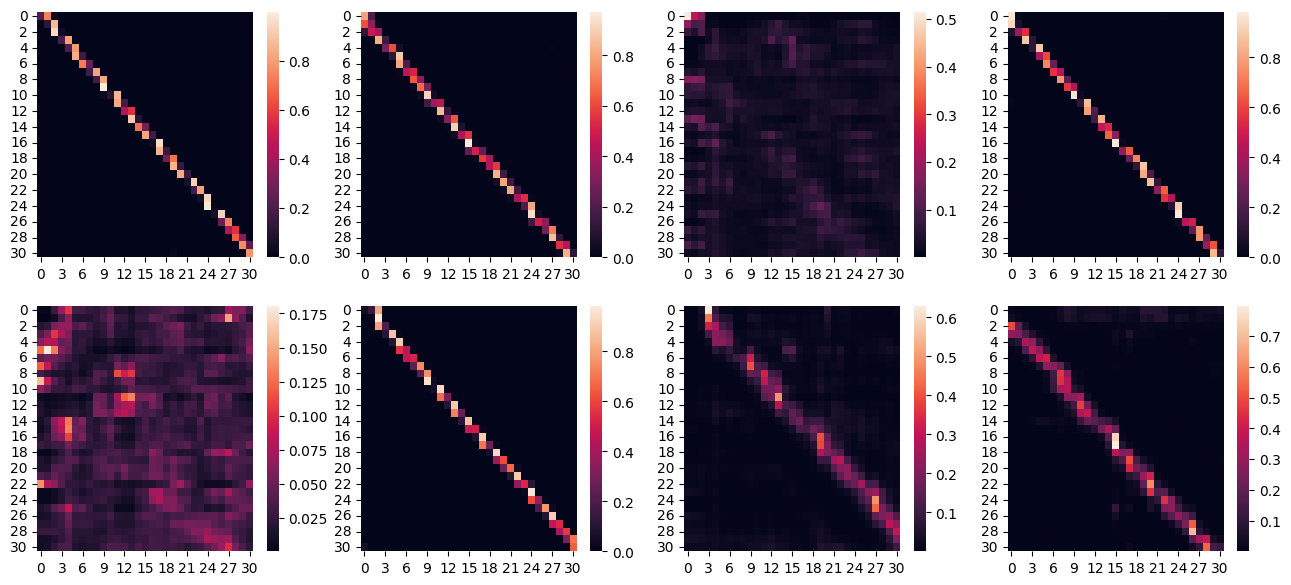


EPOCH : 4/10


100%|███████████████████████████████████████| 5543/5543 [01:25<00:00, 64.82it/s]


train_loss : 0.3078
val_loss : 0.2978
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['know', 'he', 'way']
actual tokens : ['care', 'convey', 'wishes']


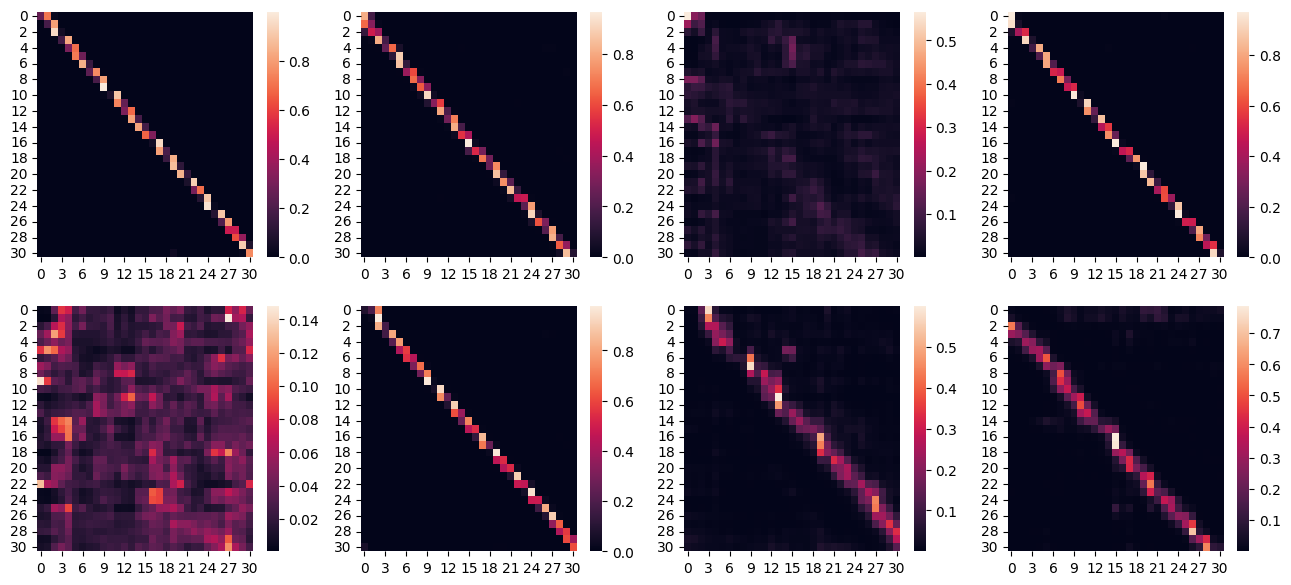


EPOCH : 5/10


100%|███████████████████████████████████████| 5543/5543 [01:25<00:00, 64.60it/s]


train_loss : 0.2962
val_loss : 0.2887
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['know', 'he', 'way']
actual tokens : ['care', 'convey', 'wishes']


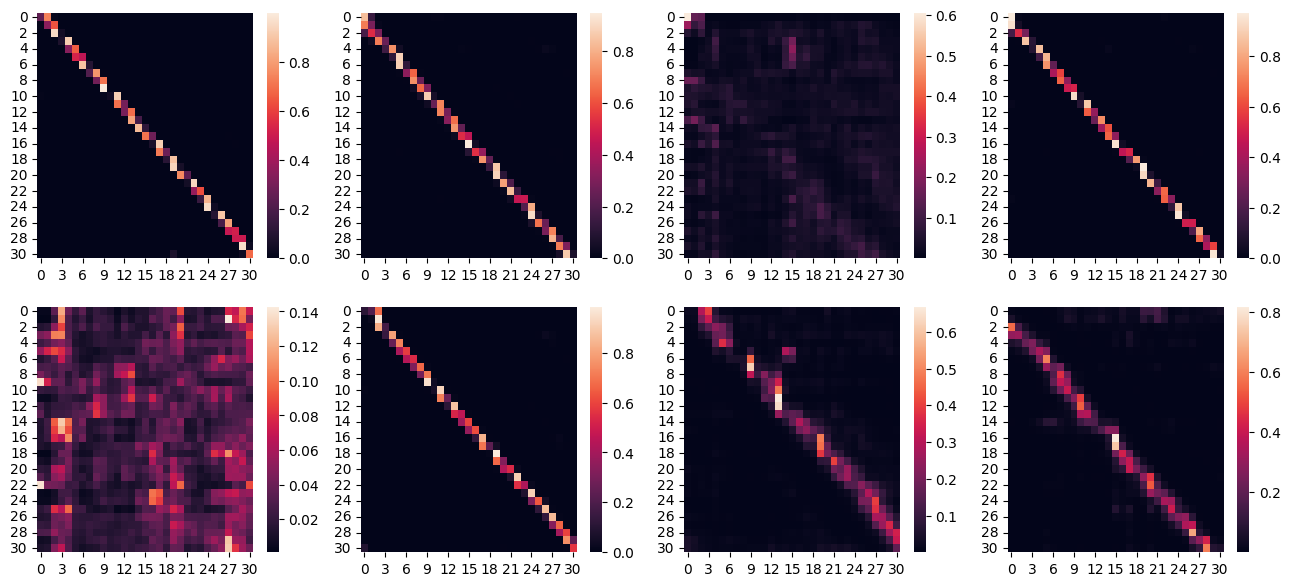


EPOCH : 6/10


100%|███████████████████████████████████████| 5543/5543 [01:26<00:00, 64.15it/s]


train_loss : 0.287
val_loss : 0.2818
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['know', 'he', 'return']
actual tokens : ['care', 'convey', 'wishes']


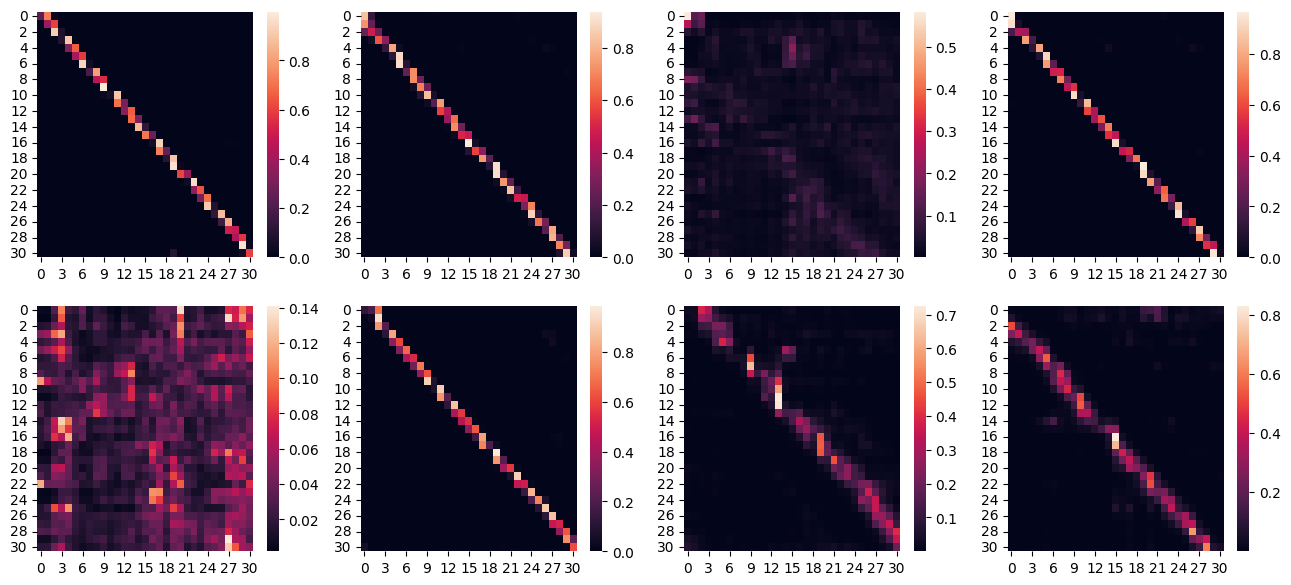


EPOCH : 7/10


100%|███████████████████████████████████████| 5543/5543 [01:26<00:00, 63.81it/s]


train_loss : 0.2796
val_loss : 0.2765
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['know', 'he', 'return']
actual tokens : ['care', 'convey', 'wishes']


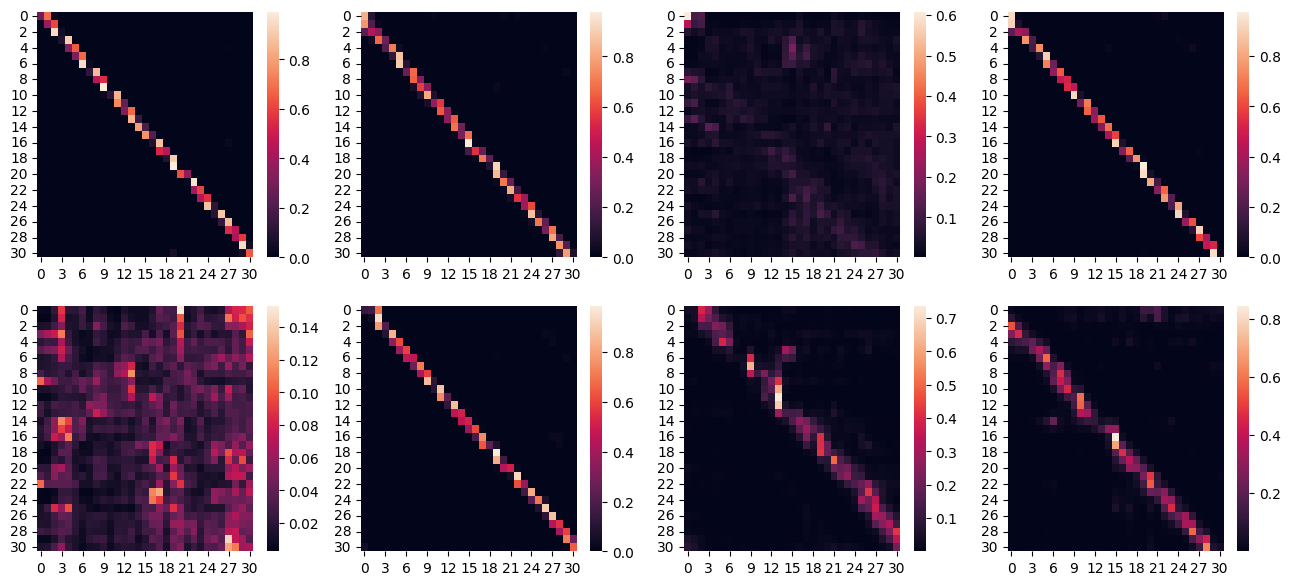


EPOCH : 8/10


100%|███████████████████████████████████████| 5543/5543 [01:26<00:00, 64.00it/s]


train_loss : 0.2733
val_loss : 0.2723
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['know', 'he', 'return']
actual tokens : ['care', 'convey', 'wishes']


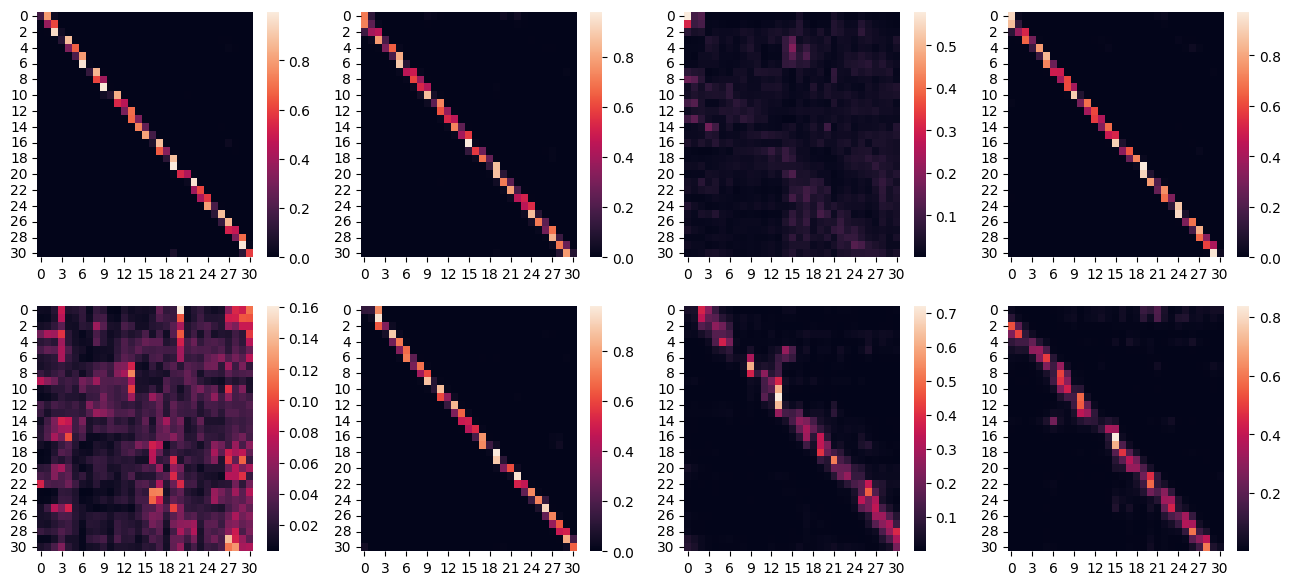


EPOCH : 9/10


100%|███████████████████████████████████████| 5543/5543 [01:26<00:00, 64.23it/s]


train_loss : 0.268
val_loss : 0.2689
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['anything', 'honor', 'return']
actual tokens : ['care', 'convey', 'wishes']


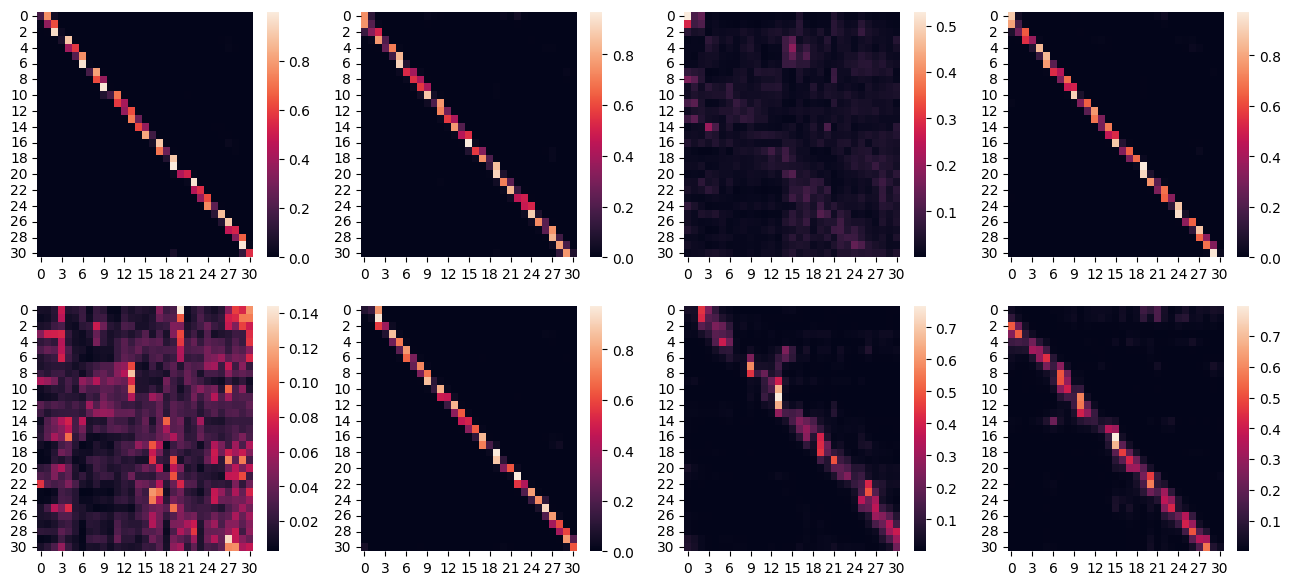


EPOCH : 10/10


100%|███████████████████████████████████████| 5543/5543 [01:26<00:00, 64.28it/s]


train_loss : 0.2635
val_loss : 0.2662
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> the colonel , who under his gr ##u ##ff ex ##ter ##i ##or really does <mask> about his grandson , <mask> ##s his good <mask> to bill via anne , <sep>

predicted tokens : ['know', 'honor', 'return']
actual tokens : ['care', 'convey', 'wishes']


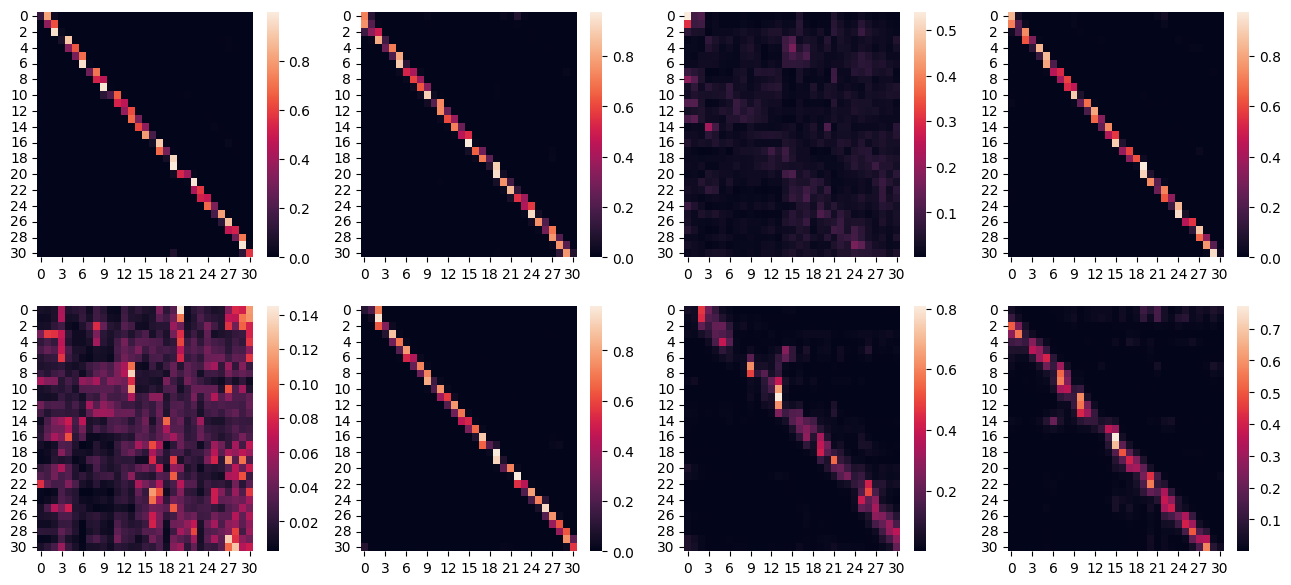

In [14]:
# start training for 10 epochs

epochs = 10

losses = {'train':[],'valid':[]}
check = []
for e in range(1,epochs+1):
    
    print(f'EPOCH : {e}/{epochs}')
    
    loss = 0
    for i,(x,y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y)
        
    train_loss = np.round((loss / (i+1)).numpy(),4)
    
    losses['train'].append(train_loss)
    loss = 0
    for i,(x,y) in enumerate(tqdm(valid)):
        loss += test_step(x,y)
        
    
    loss = np.round((loss / (i+1)).numpy(),4) 
    
    print('train_loss :',train_loss)
    print('val_loss :',loss)
    
    if e == 1:
        model.save_weights(f'Bert/bert_mlm_{e}.weights.h5')
        print('weights saved')
        
    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights(f'Bert/bert_mlm_{e}.weights.h5')
        print('weights saved')
    
    losses['valid'].append(loss)
    
    print('------------------------------------------------------------------------------------------')
    inp = ' '.join([tokenizer.i2w[t] for t in x_sample if t>0])
    
    print('INPUT :',inp+'\n')
    sample_output(x_sample,y_sample)
    
    
    
    attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

    _,ax = plt.subplots(2,4,figsize=(16,7))

    for i in range(2):
        for j in range(4):
            sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])

    plt.show()
    print()    
        


In [15]:
# load best weights

model.load_weights('Bert/bert_mlm_10.weights.h5')

In [16]:
# save weights of the 1st sequence 

# word embeddings
word_emb_weights = model.layers[1].embedding.word_emb_layer.get_weights()

# encoder layer weights
en_layer_weights = []
for layer in model.layers[1].encoder_layers:
    en_layer_weights.append(layer.get_weights())

# mlm head weights
mlm_head = model.layers[-1].get_weights()

# save all weights as pkl file
with open('Bert/pretrained_embeddings_weights.pkl','wb') as f:
    pickle.dump(word_emb_weights,f)
    
with open('Bert/pretrained_encoder_weights.pkl','wb') as f:
    pickle.dump(en_layer_weights,f)
    
with open('Bert/mlm_head.pkl','wb') as f:
    pickle.dump(mlm_head,f)

predicted tokens : ['from', 'company', '50']
actual tokens : ['in', 'startups', '80']


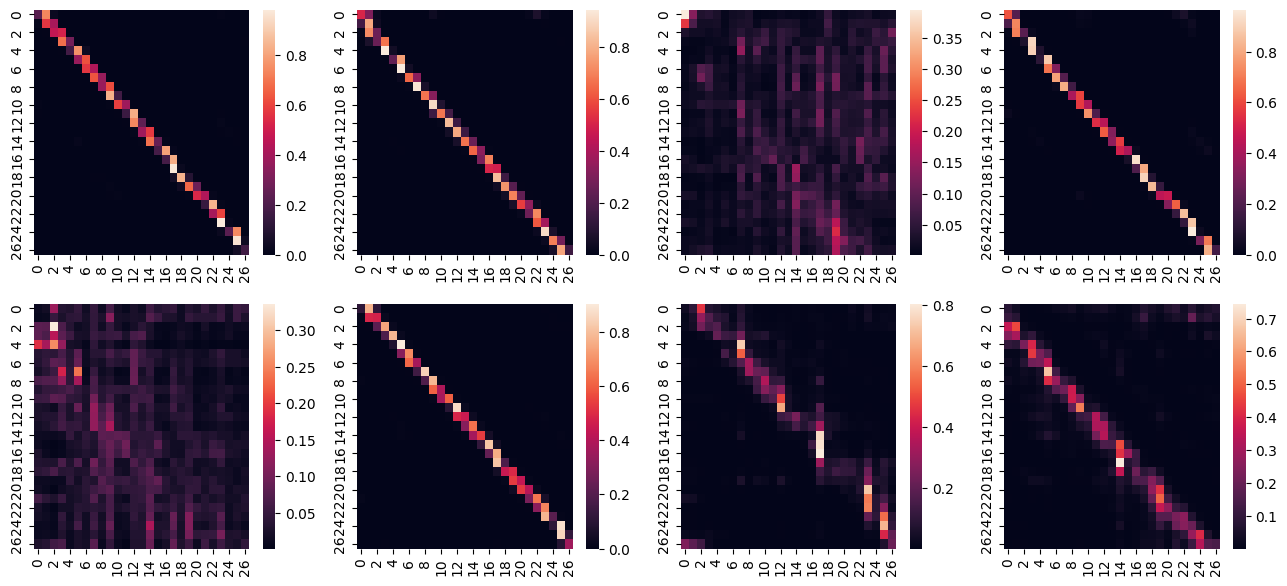

In [17]:
# check predicted token samples and visualize attention

i = np.random.randint(0,len(xvalid)-1)
x = xvalid[i]
y = yvalid[i]

sample_output(x,y)

idx = np.where(x!=0)[0][-1]

attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()

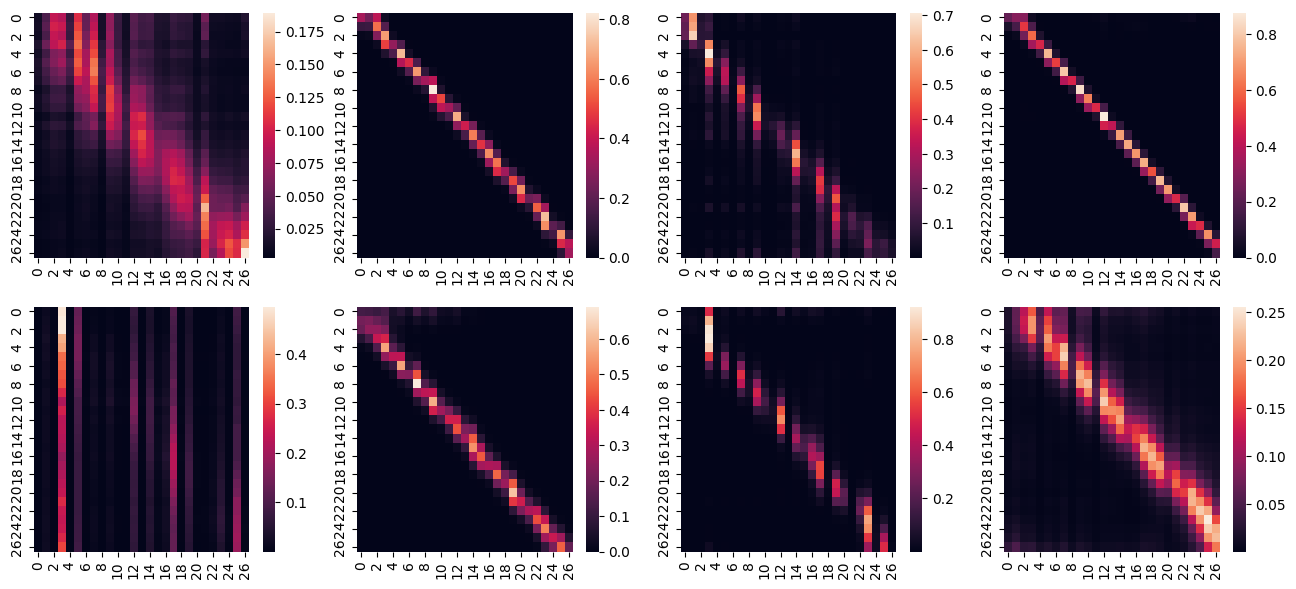

In [18]:
attn_scores = model.layers[1].encoder_layers[0].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()